In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
import altair as alt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from prettytable import PrettyTable, TableStyle

# Data Analysis Begins

- Load data

In [2]:
def load_data(option: str = "1985-2023") -> pd.DataFrame:
    df = pd.DataFrame()
    if option == "1985-2023":
        df = pd.read_excel("../data/tentative_final_with_NaN.xlsx")
    if option == "2010-2023":
        df = pd.read_excel("../data/tentative_final.xlsx")
    return df

tentative_df = load_data()
tentative_df

,County,Year,Population,crime_rate,clearance_rate,population_density,unemployment_rate,adjusted_income,poverty_rate,rent_burden,...,Category_encoded,Category_Rural,Category_Suburban,Category_Urban,uninsured_rate,high_school_rate,dropout_rate,public_school_rate,adherent_rate,rdm
0,Alameda,1985,1185500,0.009809,0.466890,1606.368564,NaN,NaN,NaN,NaN,...,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,Alameda,1986,1206900,0.010353,0.445778,1635.365854,NaN,NaN,NaN,NaN,...,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,Alameda,1987,1220600,0.009588,0.538580,1653.929539,NaN,NaN,NaN,NaN,...,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,Alameda,1988,1242300,0.008825,0.520660,1683.333333,NaN,NaN,NaN,NaN,...,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,Alameda,1989,1261200,0.008375,0.497018,1708.943089,NaN,NaN,NaN,NaN,...,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,Yuba,2019,79619,0.004095,0.411043,126.379365,6.2,201.708250,15.2,41.5,...,0,1,0,0,0.072427,82.3,0.055995,0.985,0.347593,2.0
2258,Yuba,2020,81178,0.004977,0.398515,128.853968,10.6,197.248655,16.3,37.5,...,0,1,0,0,0.071218,82.2,0.049287,0.984,0.346609,2.0
2259,Yuba,2021,82091,0.004312,0.420904,130.303175,8.4,204.337343,15.6,39.3,...,0,1,0,0,0.070699,81.2,NaN,NaN,0.342754,2.0
2260,Yuba,2022,82563,0.003379,0.433692,131.052381,5.6,199.314588,14.9,39.5,...,0,1,0,0,0.069229,82.7,0.022527,0.937,0.340794,2.0


In [3]:
tentative_df.columns

Index(['County', 'Year', 'Population', 'crime_rate', 'clearance_rate',
       'population_density', 'unemployment_rate', 'adjusted_income',
       'poverty_rate', 'rent_burden', 'home_ownership_rate',
       'mobile_home_ratio', 'vacancy_rate', 'Number_of_Persons_per_HseHld',
       'renter_ratio', 'median_age', 'adj_police_budget',
       'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value',
       'house_affordability', 'Category', 'Category_encoded', 'Category_Rural',
       'Category_Suburban', 'Category_Urban', 'uninsured_rate',
       'high_school_rate', 'dropout_rate', 'public_school_rate',
       'adherent_rate', 'rdm'],
      dtype='object')

### Load and view data

#### New features, excluding the previous crime

In [4]:
tentative_df["social_vs_security"]=(tentative_df['adj_education_budget']+tentative_df['adj_welfare_budget']+tentative_df['adj_health_budget'])/(tentative_df['adj_police_budget']+tentative_df['adj_judiciary_budget']+tentative_df['adj_prison_budget'])
tentative_df["security_vs_social"]=(tentative_df['adj_police_budget']+tentative_df['adj_judiciary_budget']+tentative_df['adj_prison_budget'])/(tentative_df['adj_education_budget']+tentative_df['adj_welfare_budget']+tentative_df['adj_health_budget'])

In [5]:
feature_0=['Population','clearance_rate',
       'population_density', 'unemployment_rate', 'adjusted_income',
       'poverty_rate', 'rent_burden', 'home_ownership_rate',
       'mobile_home_ratio', 'vacancy_rate', 'Number_of_Persons_per_HseHld',
       'renter_ratio', 'median_age', 'adj_police_budget',
       'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value',
       'house_affordability', 'uninsured_rate',
       'high_school_rate', 'dropout_rate', 'public_school_rate',
       'adherent_rate', 'rdm', "social_vs_security", "security_vs_social"]
feature_cat=['Category_Rural', 'Category_Suburban', 'Category_Urban']
crime_dataframe=tentative_df[['County', 'Year',  'crime_rate']+feature_0+feature_cat]
crime_dataframe=crime_dataframe.set_index(['County', 'Year'])
crime_dataframe.head()

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985                NaN              NaN           NaN          NaN   
        1986                NaN              NaN           NaN          NaN   
        1987                NaN              NaN           NaN          NaN   
        1988                NaN              NaN           NaN          NaN   
        1989                NaN              NaN           NaN          NaN   

              home_ownership_rate  mobile_home_ratio  ...  high_school_rate  \
County  Year                                          ...                     
Alameda 1985                  NaN                NaN  ...               NaN   
        1986                  NaN                NaN  ...               NaN   
        1987                  NaN                NaN  ...               NaN   
        1988                  NaN                NaN  ...               NaN   
        1989                  NaN                NaN  ...               NaN   

              dropout_rate  public_school_rate  adherent_rate  rdm  \
County  Year                                                         
Alameda 1985           NaN                 NaN            NaN  NaN   
        1986           NaN                 NaN            NaN  NaN   
        1987           NaN                 NaN            NaN  NaN   
        1988           NaN                 NaN            NaN  NaN   
        1989           NaN                 NaN            NaN  NaN   

              social_vs_security  security_vs_social  Category_Rural  \
County  Year                                                           
Alameda 1985                 NaN                 NaN               0   
        1986                 NaN                 NaN               0   
        1987                 NaN                 NaN               0   
        1988                 NaN                 NaN               0   
        1989                 NaN                 NaN               0   

              Category_Suburban  Category_Urban  
County  Year                                     
Alameda 1985                  0               1  
        1986                  0               1  
        1987                  0               1  
        1988                  0               1  
        1989                  0               1  

[5 rows x 35 columns]

Impute Missing Values as follows:
1) For each feature, once we fix the County, the the feature becomes a time series from 1985 to 2023 with some missing values.
2) We apply simple linear regression of Year vs feature to impute the missing values

In [6]:
crime_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2262 entries, ('Alameda', 1985) to ('Yuba', 2023)
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   crime_rate                    2262 non-null   float64
 1   Population                    2262 non-null   int64  
 2   clearance_rate                2262 non-null   float64
 3   population_density            2262 non-null   float64
 4   unemployment_rate             1914 non-null   float64
 5   adjusted_income               928 non-null    float64
 6   poverty_rate                  870 non-null    float64
 7   rent_burden                   812 non-null    float64
 8   home_ownership_rate           812 non-null    float64
 9   mobile_home_ratio             812 non-null    float64
 10  vacancy_rate                  812 non-null    float64
 11  Number_of_Persons_per_HseHld  812 non-null    float64
 12  renter_ratio                  812 no

In [7]:


# 1. Copy your original DataFrame and set a MultiIndex
df = crime_dataframe.copy()
#df = df.set_index(['County', 'Year'])

def fill_missing_with_linear_regression(group):
    """
    For a single county (group), fit a simple linear regression model
    Year vs. each numeric column. Use that model to fill missing values.
    """
    # Sort by Year for clarity
    group = group.sort_index(level='Year')
    
    # Iterate over each column
    for col in group.columns:
        # Only process numeric columns
        if pd.api.types.is_numeric_dtype(group[col]):
            # Extract the known data points (drop missing)
            valid_data = group[col].dropna()
            
            # If there aren't at least two valid points, we can't fit a regression
            if len(valid_data) < 2:
                continue
            
            # Prepare X (Year) and y (column values)
            X = valid_data.index.get_level_values('Year').values.reshape(-1, 1)
            y = valid_data.values
            
            # Fit the linear regression model
            model = LinearRegression().fit(X, y)
            
            # Predict for all years in this county
            X_all = group.index.get_level_values('Year').values.reshape(-1, 1)
            y_pred = model.predict(X_all)
            
            # Fill only missing values with the predictions
            missing_mask = group[col].isna()
            group.loc[missing_mask, col] = y_pred[missing_mask]
        else:
            print(f"Skipping non-numeric column: {col}")
    
    return group

# 2. Group by County and apply the regression-based filling
df_reg_filled = (
    df.groupby(level='County', group_keys=False)
      .apply(fill_missing_with_linear_regression)
)

df_reg_filled.head(10)

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   
        1990    0.009106     1276702        0.470067         1729.948509   
        1991    0.012014     1284782        0.386848         1740.897019   
        1992    0.012856     1302709        0.377120         1765.188347   
        1993    0.013388     1318127        0.374115         1786.079946   
        1994    0.012262     1327526        0.398820         1798.815718   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985           5.890887       198.249497     20.616190    49.471868   
        1986           5.887444       202.918528     20.301905    49.215165   
        1987           5.884002       207.587558     19.987619    48.958462   
        1988           5.880559       212.256589     19.673333    48.701758   
        1989           5.877117       216.925620     19.359048    48.445055   
        1990           5.873674       221.594651     19.044762    48.188352   
        1991           5.500000       226.263681     18.730476    47.931648   
        1992           6.600000       230.932712     18.416190    47.674945   
        1993           6.700000       235.601743     18.101905    47.418242   
        1994           6.200000       240.270774     17.787619    47.161538   

              home_ownership_rate  mobile_home_ratio  ...  high_school_rate  \
County  Year                                          ...                     
Alameda 1985             0.541511           0.013777  ...         53.839341   
        1986             0.541334           0.013726  ...         54.807253   
        1987             0.541157           0.013674  ...         55.775165   
        1988             0.540979           0.013623  ...         56.743077   
        1989             0.540802           0.013572  ...         57.710989   
        1990             0.540625           0.013520  ...         58.678901   
        1991             0.540447           0.013469  ...         59.646813   
        1992             0.540270           0.013417  ...         60.614725   
        1993             0.540093           0.013366  ...         61.582637   
        1994             0.539915           0.013315  ...         62.550549   

              dropout_rate  public_school_rate  adherent_rate       rdm  \
County  Year                                                              
Alameda 1985      0.038731            0.928594       0.167093  2.195604   
        1986      0.038225            0.927948       0.173917  2.248352   
        1987      0.037719            0.927301       0.180741  2.301099   
        1988      0.037213            0.926655       0.187565  2.353846   
        1989      0.036707            0.926009       0.194389  2.406593   
        1990      0.036201            0.925363       0.201213  2.459341   
        1991      0.035695            0.924717       0.208036  2.512088   
        1992      0.035189            0.924070       0.214860  2.564835   
        1993      0.034683            0.923424       0.221684  2.617582   
        1994      0.034177            0.922778       0.228508  2.670330   

              social_vs_security  security_vs_social  Category_Rural  \
County  Year                                                           
Alameda 1985            2.132060            0.394342               0   
        1986            2.135405            0.396383               0   
        1987  

We plot a couple to see the imputation worked

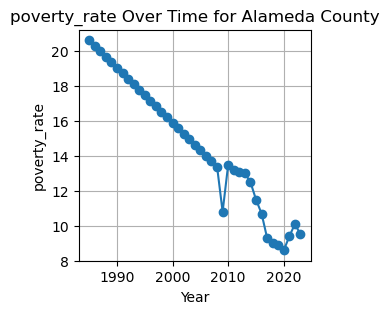

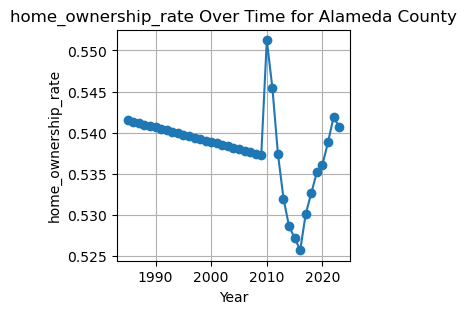

In [8]:
import matplotlib.pyplot as plt

# Filter data for Alameda county (the index for the first level is County)
df_alameda = df_reg_filled.loc['Alameda']

# Plot the adjusted_income column with Year on the x-axis
plt.figure(figsize=(3,3))
plt.plot(df_alameda.index, df_alameda['poverty_rate'], marker='o')
plt.xlabel('Year')
plt.ylabel('poverty_rate')
plt.title('poverty_rate Over Time for Alameda County')
plt.grid(True)
plt.show()

plt.figure(figsize=(3,3))
plt.plot(df_alameda.index, df_alameda['home_ownership_rate'], marker='o')
plt.xlabel('Year')
plt.ylabel('home_ownership_rate')
plt.title('home_ownership_rate Over Time for Alameda County')
plt.grid(True)
plt.show()

Seems like all the budgets are missing for San Fransisco??

In [9]:
for col in df_reg_filled.columns:
    XX=df_reg_filled[[col]].isna()
    XX=XX[XX[col]==True]
    if len(XX)>0:
        print(XX)

                    adj_police_budget
County        Year                   
San Francisco 1985               True
              1986               True
              1987               True
              1988               True
              1989               True
              1990               True
              1991               True
              1992               True
              1993               True
              1994               True
              1995               True
              1996               True
              1997               True
              1998               True
              1999               True
              2000               True
              2001               True
              2002               True
              2003               True
              2004               True
              2005               True
              2006               True
              2007               True
              2008               True
            

In [10]:
final_dataframe = df_reg_filled
final_dataframe=final_dataframe.dropna()
final_dataframe.columns

Index(['crime_rate', 'Population', 'clearance_rate', 'population_density',
       'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden',
       'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate',
       'Number_of_Persons_per_HseHld', 'renter_ratio', 'median_age',
       'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value',
       'house_affordability', 'uninsured_rate', 'high_school_rate',
       'dropout_rate', 'public_school_rate', 'adherent_rate', 'rdm',
       'social_vs_security', 'security_vs_social', 'Category_Rural',
       'Category_Suburban', 'Category_Urban'],
      dtype='object')

In [11]:
final_dataframe.shape

(2030, 35)

In [12]:
Urban_df=final_dataframe[final_dataframe["Category_Urban"]==1]
Urban_df=Urban_df.drop(['Category_Rural', 'Category_Suburban',
       'Category_Urban'],axis=1)
Urban_df.head()

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985           5.890887       198.249497     20.616190    49.471868   
        1986           5.887444       202.918528     20.301905    49.215165   
        1987           5.884002       207.587558     19.987619    48.958462   
        1988           5.880559       212.256589     19.673333    48.701758   
        1989           5.877117       216.925620     19.359048    48.445055   

              home_ownership_rate  mobile_home_ratio  ...  median_house_value  \
County  Year                                          ...                       
Alameda 1985             0.541511           0.013777  ...      -574063.956044   
        1986             0.541334           0.013726  ...      -533885.054945   
        1987             0.541157           0.013674  ...      -493706.153846   
        1988             0.540979           0.013623  ...      -453527.252747   
        1989             0.540802           0.013572  ...      -413348.351648   

              house_affordability  uninsured_rate  high_school_rate  \
County  Year                                                          
Alameda 1985             6.598017        0.359035         53.839341   
        1986             6.625489        0.350230         54.807253   
        1987             6.652962        0.341424         55.775165   
        1988             6.680434        0.332619         56.743077   
        1989             6.707907        0.323813         57.710989   

              dropout_rate  public_school_rate  adherent_rate       rdm  \
County  Year                                                              
Alameda 1985      0.038731            0.928594       0.167093  2.195604   
        1986      0.038225            0.927948       0.173917  2.248352   
        1987      0.037719            0.927301       0.180741  2.301099   
        1988      0.037213            0.926655       0.187565  2.353846   
        1989      0.036707            0.926009       0.194389  2.406593   

              social_vs_security  security_vs_social  
County  Year                                          
Alameda 1985            2.132060            0.394342  
        1986            2.135405            0.396383  
        1987            2.138751            0.398423  
        1988            2.142097            0.400463  
        1989            2.145442            0.402504  

[5 rows x 32 columns]

In [13]:
Subrban_df=final_dataframe[final_dataframe["Category_Suburban"]==1]
Suburban_df=Subrban_df.drop(['Category_Rural', 'Category_Suburban',
       'Category_Urban'],axis=1)
Suburban_df.head()

crime_rate  Population  clearance_rate  population_density  \
County Year                                                               
Butte  1985    0.003845      159700        0.400651           99.563591   
       1986    0.005178      163000        0.425355          101.620948   
       1987    0.004483      166200        0.440268          103.615960   
       1988    0.004362      170800        0.546309          106.483791   
       1989    0.004058      175200        0.555556          109.226933   

             unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County Year                                                                  
Butte  1985          10.588102       148.688655     27.770238    55.809890   
       1986          10.490709       149.908188     27.502381    55.648352   
       1987          10.393316       151.127720     27.234524    55.486813   
       1988          10.295922       152.347253     26.966667    55.325275   
       1989          10.198529       153.566786     26.698810    55.163736   

             home_ownership_rate  mobile_home_ratio  ...  median_house_value  \
County Year                                          ...                       
Butte  1985             0.652191           0.193721  ...       -61965.054945   
       1986             0.650298           0.191548  ...       -51330.109890   
       1987             0.648404           0.189375  ...       -40695.164835   
       1988             0.646511           0.187203  ...       -30060.219780   
       1989             0.644618           0.185030  ...       -19425.274725   

             house_affordability  uninsured_rate  high_school_rate  \
County Year                                                          
Butte  1985             6.436580        0.439181         41.988791   
       1986             6.406308        0.428701         43.320440   
       1987             6.376036        0.418220         44.652088   
       1988             6.345764        0.407740         45.983736   
       1989             6.315492        0.397259         47.315385   

             dropout_rate  public_school_rate  adherent_rate       rdm  \
County Year                                                              
Butte  1985      0.058017            0.882461       0.416623 -1.472527   
       1986      0.056749            0.884592       0.412978 -1.373626   
       1987      0.055481            0.886723       0.409332 -1.274725   
       1988      0.054212            0.888853       0.405686 -1.175824   
       1989      0.052944            0.890984       0.402041 -1.076923   

             social_vs_security  security_vs_social  
County Year                                          
Butte  1985            4.563705            0.100749  
       1986            4.500192            0.110091  
       1987            4.436679            0.119433  
       1988            4.373166            0.128775  
       1989            4.309653            0.138117  

[5 rows x 32 columns]

In [14]:
Rural_df=final_dataframe[final_dataframe["Category_Rural"]==1]
Rural_df=Rural_df.drop(['Category_Rural', 'Category_Suburban','Category_Urban'],axis=1)
Rural_df.head()

crime_rate  Population  clearance_rate  population_density  \
County Year                                                               
Amador 1985    0.003624       21800        0.860759           35.973597   
       1986    0.001648       22450        0.756757           37.046205   
       1987    0.002060       23300        0.729167           38.448845   
       1988    0.002835       25750        0.712329           42.491749   
       1989    0.001486       27600        0.829268           45.544554   

             unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County Year                                                                  
Amador 1985           7.492758       225.179234     18.312619    67.166813   
       1986           7.483033       225.272053     18.106190    66.462198   
       1987           7.473307       225.364871     17.899762    65.757582   
       1988           7.463581       225.457690     17.693333    65.052967   
       1989           7.453855       225.550508     17.486905    64.348352   

             home_ownership_rate  mobile_home_ratio  ...  median_house_value  \
County Year                                          ...                       
Amador 1985             0.717260           0.075365  ...        71045.934066   
       1986             0.718966           0.075160  ...        78734.725275   
       1987             0.720671           0.074955  ...        86423.516484   
       1988             0.722377           0.074750  ...        94112.307692   
       1989             0.724083           0.074545  ...       101801.098901   

             house_affordability  uninsured_rate  high_school_rate  \
County Year                                                          
Amador 1985             7.371452        0.291578         40.394725   
       1986             7.302376        0.284776         41.789451   
       1987             7.233301        0.277975         43.184176   
       1988             7.164225        0.271173         44.578901   
       1989             7.095150        0.264372         45.973626   

             dropout_rate  public_school_rate  adherent_rate       rdm  \
County Year                                                              
Amador 1985      0.017621            0.950014       0.189945  1.703297   
       1986      0.018660            0.950634       0.192253  1.692308   
       1987      0.019700            0.951253       0.194561  1.681319   
       1988      0.020739            0.951872       0.196869  1.670330   
       1989      0.021779            0.952491       0.199178  1.659341   

             social_vs_security  security_vs_social  
County Year                                          
Amador 1985            0.621030            1.370080  
       1986            0.634628            1.356999  
       1987            0.648226            1.343917  
       1988            0.661824            1.330836  
       1989            0.675422            1.317755  

[5 rows x 32 columns]

Get test and train datasets

In [15]:
train_Urban, test_Urban = train_test_split(Urban_df, test_size=0.15, random_state=42)
train_Suburban, test_Suburban = train_test_split(Suburban_df, test_size=0.15, random_state=42)
train_Rural, test_Rural = train_test_split(Rural_df, test_size=0.15, random_state=42)

### Regression Analysis

Codes to help with regression analysis

In [16]:
# A function to fit models
def fit_models(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    **models
) -> tuple[dict, dict[dict,], dict[dict,]]:
    """
    Fit nodels an compute compute their root mean square errors,
    mean square errors and r2 socres

    Parameters:
    X_train(pd.DataFrame): features-train data
    X_test(pd.DataFrame): features-test data
    y_train(pd.DataFrame): target-train data
    y_test(pd.DataFrame): target-test data
    models: A dictionary of models

    Returns:
    dict: A tuple (dict, dict, dict).
    - First dict: The fitted models
    - Second dict: A dictionary of dictionaries.
        Each dictionary contains two lists [root mean square errors, mean square errors, r2 socres].
        One for train data and the other for test data.
    - Third dict: A dictionary of dictionaries.
        Each dictionary contains two predicted values.
        One for train data and the other for test data.
    """

    model_stats = {}
    fitted_models = {}
    predicted_values = {}

    for key, model in models.items():
        # Fit the models to the training data
        model.fit(X_train, y_train)

        # Find the model predictions on the training set
        train_preds = model.predict(X_train)

        # Find the model predictions on the test set
        test_preds = model.predict(X_test)

        # Find the mse on the training set
        train_mse = mean_squared_error(y_train, train_preds)
        train_rmse = root_mean_squared_error(y_train, train_preds)
        train_r2score = r2_score(y_train, train_preds)

        # Find the mse on the test set
        test_mse = mean_squared_error(y_test, test_preds)
        test_rmse = root_mean_squared_error(y_test, test_preds)
        test_r2score = r2_score(y_test, test_preds)

        fitted_models[key] = model
        model_stats[key] = {
            "train": [train_mse, train_rmse, train_r2score],
            "test": [test_mse, test_rmse, test_r2score],
        }
        predicted_values[key] = {"train": train_preds, "test": test_preds}

    return fitted_models, model_stats, predicted_values

In [17]:
# A function to fit models with cross-validation
def cross_fit_models(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    **models
) -> tuple[dict, dict[dict,], dict[dict,]]:
    """
    Fit nodels an compute compute their root mean square errors,
    mean square errors and r2 socres

    Parameters:
    X_train(pd.DataFrame): features-train data
    X_test(pd.DataFrame): features-test data
    y_train(pd.DataFrame): target-train data
    y_test(pd.DataFrame): target-test data
    models: A dictionary of models

    Returns:
    dict: A tuple (dict, dict, dict).
    - First dict: The fitted models
    - Second dict: A dictionary of dictionaries.
        Each dictionary contains two lists [root mean square errors, mean square errors, r2 socres].
        One for train data and the other for test data.
    - Third dict: A dictionary of dictionaries.
        Each dictionary contains two predicted values.
        One for train data and the other for test data.
    """

    model_stats = {}
    fitted_models = {}
    predicted_values = {}

    for key, model in models.items():
        # Fit the models to the training data
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        train_mse = []
        train_rmse = []
        train_r2score = []
        test_mse = []
        test_rmse = []
        test_r2score = []
        for train_index, val_index in kf.split(X_train):
            X_tt, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_tt, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            model.fit(X_tt, y_tt)
            # Find the model predictions on the training set
            train_preds = model.predict(X_tt)

            # Find the model predictions on the test set
            test_preds = model.predict(X_val)

            # Find the mse on the training set
            train_mse.append( mean_squared_error(y_tt, train_preds))
            train_rmse.append( root_mean_squared_error(y_tt, train_preds))
            train_r2score.append( r2_score(y_tt, train_preds))

            # Find the mse on the test set
            test_mse.append( mean_squared_error(y_val, test_preds))
            test_rmse.append( root_mean_squared_error(y_val, test_preds))
            test_r2score.append( r2_score(y_val, test_preds))

        model.fit(X_train, y_train)
        fitted_models[key] = model
        model_stats[key] = {
            "train": [np.mean(train_mse), np.mean(train_rmse), np.mean(train_r2score)],
            "test": [np.mean(test_mse), np.mean(test_rmse), np.mean(test_r2score)],
        }
        

    return fitted_models, model_stats

In [18]:
def optimal_subset(ss, X_train, y_train):
    ll=list(ss)
    #if len(ll)%10==0:
        #print("len is",len(ll))
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    R2_val_scores = []
    XX=X_train[ll]
    for train_index, val_index in kf.split(X_train):
        lin_model = LinearRegression()
        X_tt, X_val = XX.iloc[train_index], XX.iloc[val_index]
        y_tt, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        lin_model.fit(X_tt, y_tt)
        y_pred = lin_model.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        R2_val_scores.append(r2)
    r_initial=np.mean(R2_val_scores)
    if len(ss)==1:
        if r_initial>0:
            return set(ss)
        else:
            return set()

    for xx in ll:
        ss.remove(xx)
        R2_val_scores = []
        l1=list(ss)
        XX=X_train[l1]
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(X_train):
            lin_model = LinearRegression()
            X_tt, X_val = XX.iloc[train_index], XX.iloc[val_index]
            y_tt, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            lin_model.fit(X_tt, y_tt)
            y_pred = lin_model.predict(X_val)
            r2 = r2_score(y_val, y_pred)
            R2_val_scores.append(r2)
        r_now=np.mean(R2_val_scores)
        if r_now>r_initial:
            return optimal_subset(ss,X_train, y_train)
        ss.add(xx)
    return set(ss)

In [19]:
def print_table(model_stats):
    table = PrettyTable()
    table.field_names = ["Model", "Type", "MSE", "RMSE", "r2 Score"]

    for key, stat in model_stats.items():
        table.add_rows(
            [
                [key, "train data", stat["train"][0], stat["train"][1], stat["train"][2]],
                ["", "test data", stat["test"][0], stat["test"][1], stat["test"][2]],
            ],
            divider=True,
        )
    table.set_style(TableStyle.DOUBLE_BORDER)
    print(table)

In [20]:
def feature_importance(fitted_models,features,size):
    coeffs_mlr = fitted_models["mlr"].named_steps["Lin"].coef_
    sorted_indices_mlr = np.argsort(coeffs_mlr)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_mlr], coeffs_mlr[sorted_indices_mlr])
    plt.title("Linear Regression Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(coeffs_mlr[i]),features[i]) for i in sorted_indices_mlr]
    ll.sort(reverse=True)
    print('The top 4 important features in mlr is')
    for xx in ll[:4]:
        print(xx[1])

    coeffs_ridge = fitted_models["ridge"].named_steps['ridge'].coef_
    sorted_indices_ridge = np.argsort(coeffs_ridge)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_ridge], coeffs_ridge[sorted_indices_ridge])
    plt.title("Ridge Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(coeffs_ridge[i]),features[i]) for i in sorted_indices_ridge]
    ll.sort(reverse=True)
    print('The top 4 important features in ridge is')
    for xx in ll[:4]:
        print(xx[1])

    importance_xgb = fitted_models["xgb"].feature_importances_
    sorted_indices_xgb = np.argsort(importance_xgb)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
    plt.title("XGB Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(importance_xgb[i]),features[i]) for i in sorted_indices_xgb]
    ll.sort(reverse=True)
    print('The top 4 important features in xgb is')
    for xx in ll[:4]:
        print(xx[1])


    importance_randomforest = fitted_models["random_forest"].named_steps["randomforest"].feature_importances_
    sorted_indices_randomforest = np.argsort(importance_randomforest)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_randomforest], importance_randomforest[sorted_indices_randomforest])
    plt.title("RandomForest Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(importance_randomforest[i]),features[i]) for i in sorted_indices_randomforest]
    ll.sort(reverse=True)
    print('The top 4 important features in randomforest is')
    for xx in ll[:4]:
        print(xx[1])

In [21]:
def Poly_df_function(df0):
    poly=PolynomialFeatures(degree=2,include_bias=False)
    Poly_data=poly.fit_transform(df0)
    feature_names=poly.get_feature_names_out(input_features=df0.columns)
    Poly_df=pd.DataFrame(Poly_data,columns=feature_names)
    return Poly_df


def optimal_Poly_subset(Poly_df, y_train):
    ll = list(Poly_df.columns)
    N = len(ll)
    S0 = set()
    # Iterate backward in steps of 10
    for i in range(N-10, -1, -10):
        S0 = S0.union(set(ll[i:i+10]))
        S1 = optimal_subset(S0, Poly_df, y_train)
        S0 = S1
    return S0


Urban models

In [22]:
# Regression models to train
print("Urban models")

Xtrain_Urban = train_Urban[feature_0]
ytrain_Urban = train_Urban['crime_rate']

print("\nfeature 0")
print(len(feature_0),feature_0)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

fitted_models_urban0, models_stats_urban0 = cross_fit_models(
    Xtrain_Urban[feature_0], ytrain_Urban, **models
)

# Using pretty table
print_table(models_stats_urban0)

#feature_importance(fitted_models_urban0, feature_0, (4, 4))


print("\noptimal subset of feature 0")
Urban_features=list(optimal_subset(set(feature_0), Xtrain_Urban, ytrain_Urban))
print(len(Urban_features),Urban_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_models_urban, models_stats_urban = cross_fit_models(
    Xtrain_Urban[Urban_features], ytrain_Urban, **models
)

# Using pretty table
print_table(models_stats_urban)

#feature_importance(fitted_models_urban, Urban_features, (4, 4))

#Include interaction terms in the model

print("\n include optimal subset of interaction terms")
Poly_df=Poly_df_function(Xtrain_Urban[feature_0])
Urban_Poly_features=list(optimal_Poly_subset(Poly_df, ytrain_Urban))
print(len(Urban_Poly_features),Urban_Poly_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_Poly_models_urban, Poly_models_stats_urban = cross_fit_models(
    Poly_df[Urban_Poly_features], ytrain_Urban, **models
)

# Using pretty table
print_table(Poly_models_stats_urban)

#feature_importance(fitted_Poly_models_urban, Urban_Poly_features, (4, 4))



Urban models

feature 0
31 ['Population', 'clearance_rate', 'population_density', 'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden', 'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate', 'Number_of_Persons_per_HseHld', 'renter_ratio', 'median_age', 'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value', 'house_affordability', 'uninsured_rate', 'high_school_rate', 'dropout_rate', 'public_school_rate', 'adherent_rate', 'rdm', 'social_vs_security', 'security_vs_social']
╔═══════════════╦════════════╦════════════════════════╦════════════════════════╦════════════════════╗
║     Model     ║    Type    ║          MSE           ║          RMSE          ║      r2 Score      ║
╠═══════════════╬════════════╬════════════════════════╬════════════════════════╬════════════════════╣
║      mlr      ║ train data ║ 1.6597083682420437

In [23]:
y_pred=fitted_Poly_models_urban["mlr"].predict(Poly_df[Urban_Poly_features])
y=ytrain_Urban

urb=Xtrain_Urban.copy()
urb["error"]=y-y_pred

In [24]:
# Regression models to train
print("Suburban models")

Xtrain_Suburban = train_Suburban[feature_0]
ytrain_Suburban = train_Suburban['crime_rate']

print("\nfeature 0")
print(len(feature_0),feature_0)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

fitted_models_Suburban0, models_stats_Suburban0 = cross_fit_models(
    Xtrain_Suburban[feature_0], ytrain_Suburban, **models
)

# Using pretty table
print_table(models_stats_Suburban0)

#feature_importance(fitted_models_Suburban0, feature_0, (4, 4))


print("\noptimal subset of feature 0")
Suburban_features=list(optimal_subset(set(feature_0), Xtrain_Suburban, ytrain_Suburban))
print(len(Suburban_features),Suburban_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_models_Suburban, models_stats_Suburban = cross_fit_models(
    Xtrain_Suburban[Suburban_features], ytrain_Suburban, **models
)

# Using pretty table
print_table(models_stats_Suburban)

#feature_importance(fitted_models_Suburban, Suburban_features, (4, 4))

#Include interaction terms in the model

print("\n include optimal subset of interaction terms")
Poly_df=Poly_df_function(Xtrain_Suburban[feature_0])
Suburban_Poly_features=list(optimal_Poly_subset(Poly_df, ytrain_Suburban))

print(len(Suburban_Poly_features),Suburban_Poly_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_Poly_models_Suburban, Poly_models_stats_Suburban = cross_fit_models(
    Poly_df[Suburban_Poly_features], ytrain_Suburban, **models
)

# Using pretty table
print_table(Poly_models_stats_Suburban)

#feature_importance(fitted_Poly_models_Suburban, Suburban_Poly_features, (4, 4))



Suburban models

feature 0
31 ['Population', 'clearance_rate', 'population_density', 'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden', 'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate', 'Number_of_Persons_per_HseHld', 'renter_ratio', 'median_age', 'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value', 'house_affordability', 'uninsured_rate', 'high_school_rate', 'dropout_rate', 'public_school_rate', 'adherent_rate', 'rdm', 'social_vs_security', 'security_vs_social']
╔═══════════════╦════════════╦════════════════════════╦═══════════════════════╦════════════════════╗
║     Model     ║    Type    ║          MSE           ║          RMSE         ║      r2 Score      ║
╠═══════════════╬════════════╬════════════════════════╬═══════════════════════╬════════════════════╣
║      mlr      ║ train data ║ 1.2454513295527315

In [25]:
y_pred=fitted_Poly_models_Suburban["mlr"].predict(Poly_df[Suburban_Poly_features])

sub=Xtrain_Suburban.copy()
sub["error"]=ytrain_Suburban-y_pred

In [26]:
# Regression models to train
print("Rural models")

Xtrain_Rural = train_Rural[feature_0]
ytrain_Rural = train_Rural['crime_rate']

print("\nfeature 0")
print(len(feature_0),feature_0)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

fitted_models_Rural0, models_stats_Rural0 = cross_fit_models(
    Xtrain_Rural[feature_0], ytrain_Rural, **models
)

# Using pretty table
print_table(models_stats_Rural0)

#feature_importance(fitted_models_Rural0, feature_0, (4, 4))


print("\noptimal subset of feature 0")
Rural_features=list(optimal_subset(set(feature_0), Xtrain_Rural, ytrain_Rural))
print(len(Urban_features),Urban_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_models_Rural, models_stats_Rural = cross_fit_models(
    Xtrain_Rural[Rural_features], ytrain_Rural, **models
)

# Using pretty table
print_table(models_stats_Rural)

#feature_importance(fitted_models_Rural, Rural_features, (4, 4))

#Include interaction terms in the model

print("\n include optimal subset of interaction terms")
Poly_df=Poly_df_function(Xtrain_Rural[feature_0])
Rural_Poly_features=list(optimal_Poly_subset(Poly_df, ytrain_Rural))
print(len(Rural_Poly_features),Rural_Poly_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_Poly_models_Rural, Poly_models_stats_Rural = cross_fit_models(
    Poly_df[Rural_Poly_features], ytrain_Rural, **models
)

# Using pretty table
print_table(Poly_models_stats_Rural)

#feature_importance(fitted_Poly_models_Rural, Rural_Poly_features, (4, 4))



Rural models

feature 0
31 ['Population', 'clearance_rate', 'population_density', 'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden', 'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate', 'Number_of_Persons_per_HseHld', 'renter_ratio', 'median_age', 'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value', 'house_affordability', 'uninsured_rate', 'high_school_rate', 'dropout_rate', 'public_school_rate', 'adherent_rate', 'rdm', 'social_vs_security', 'security_vs_social']
╔═══════════════╦════════════╦════════════════════════╦════════════════════════╦═════════════════════╗
║     Model     ║    Type    ║          MSE           ║          RMSE          ║       r2 Score      ║
╠═══════════════╬════════════╬════════════════════════╬════════════════════════╬═════════════════════╣
║      mlr      ║ train data ║ 2.5203339080679

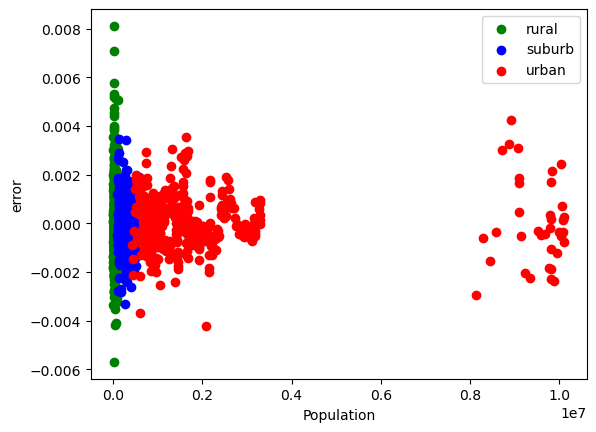

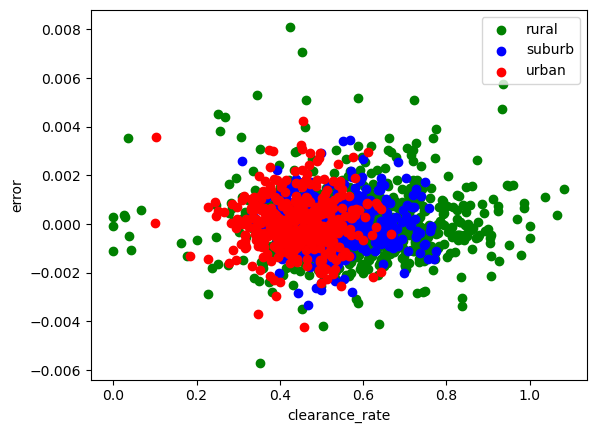

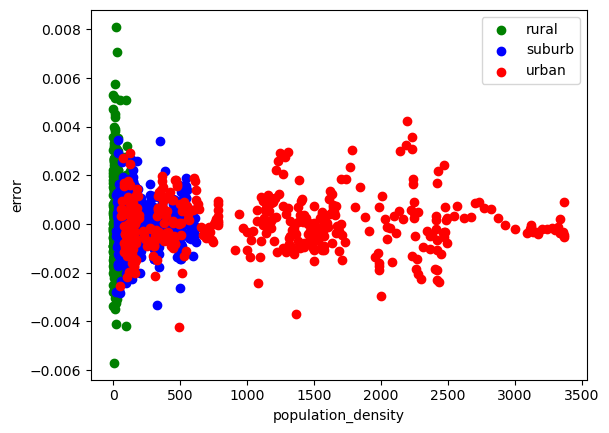

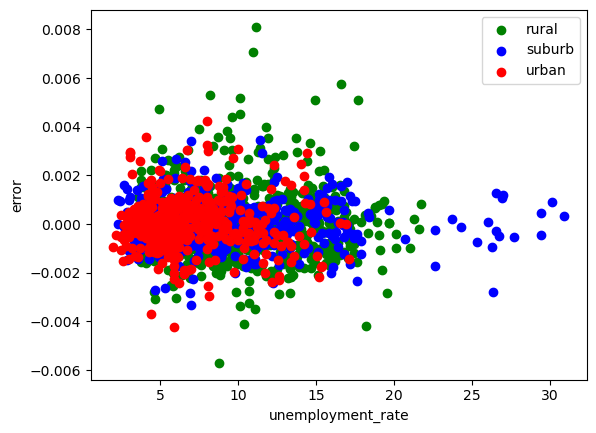

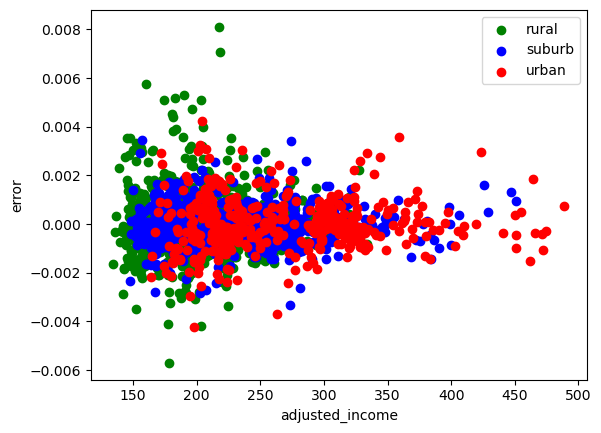

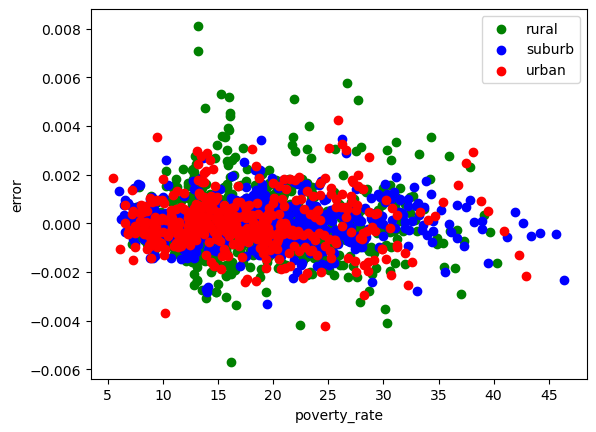

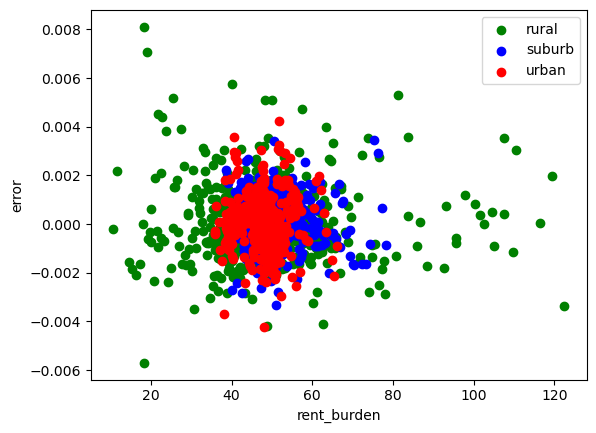

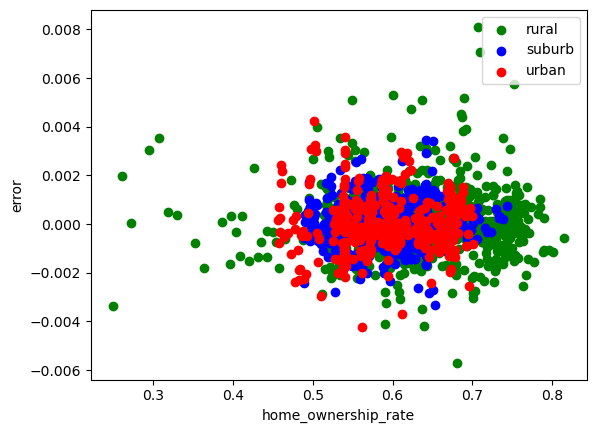

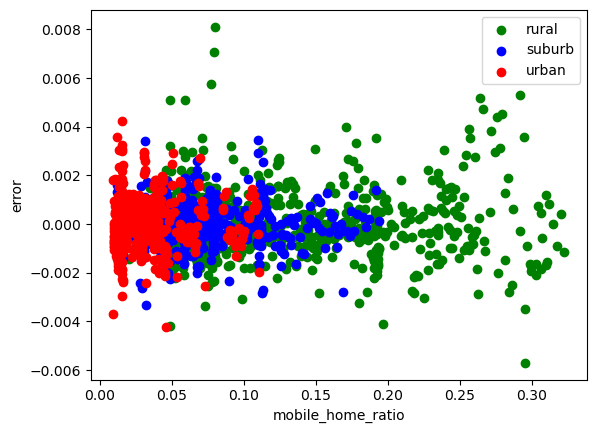

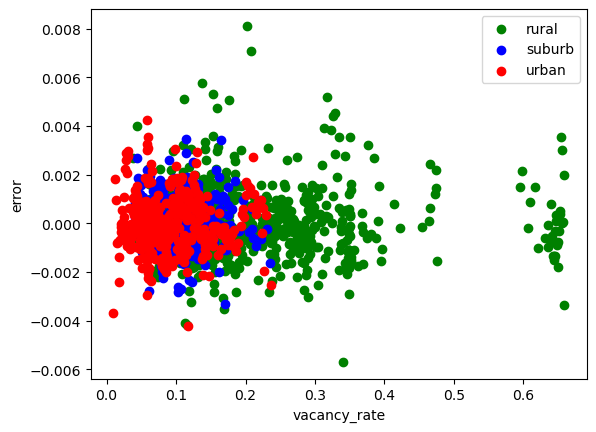

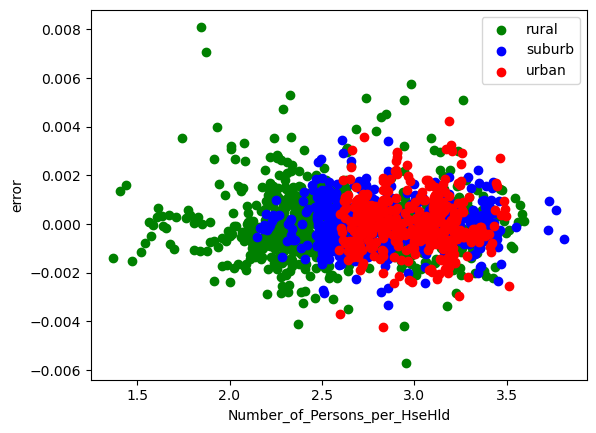

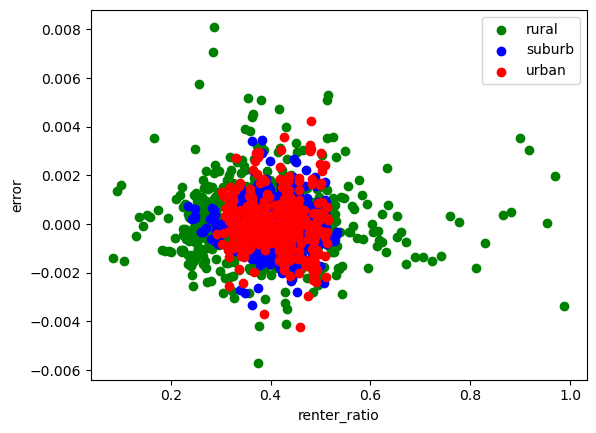

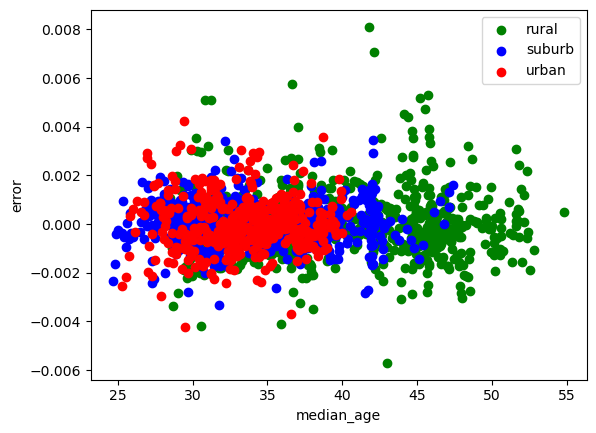

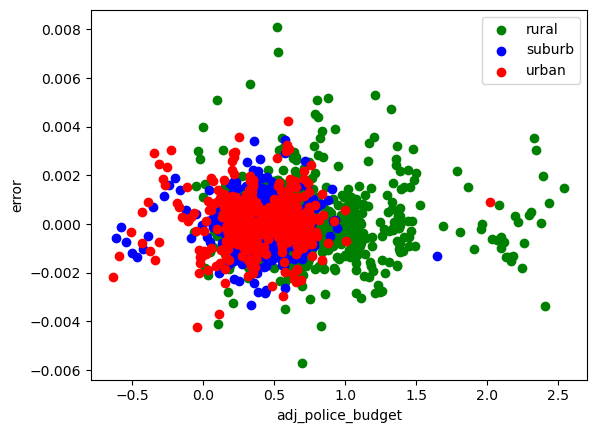

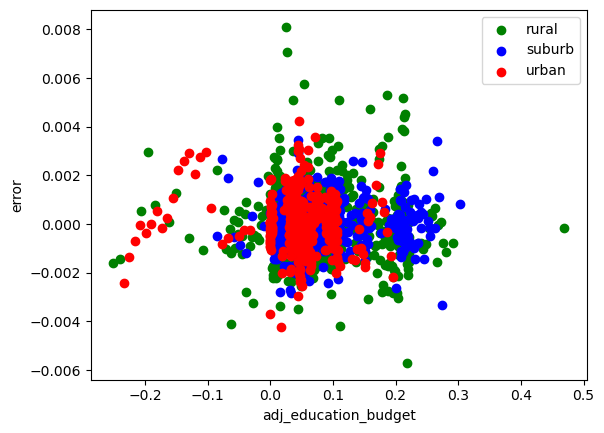

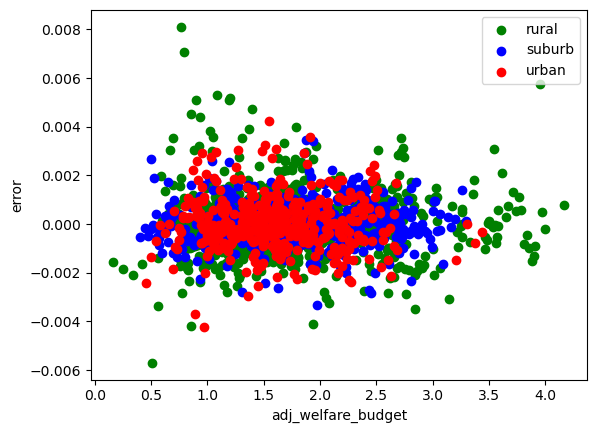

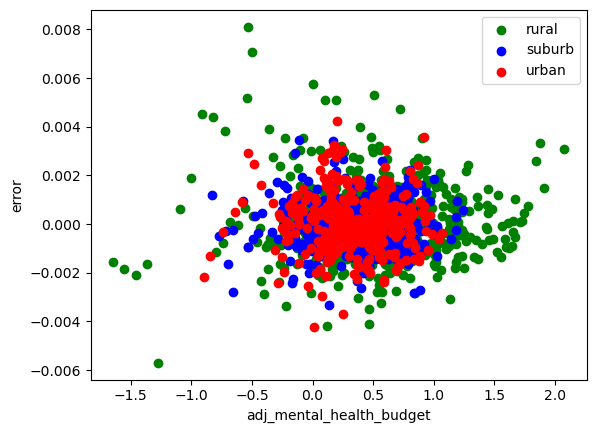

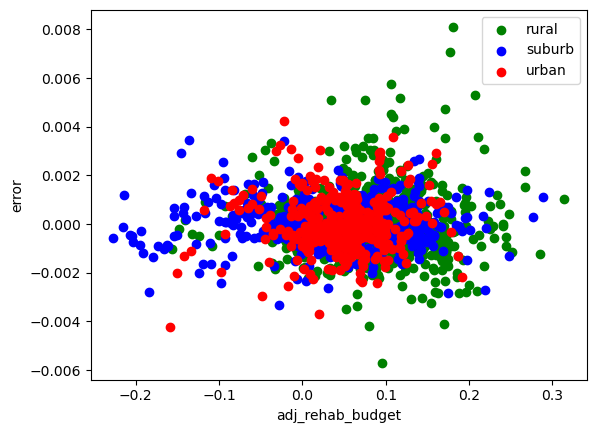

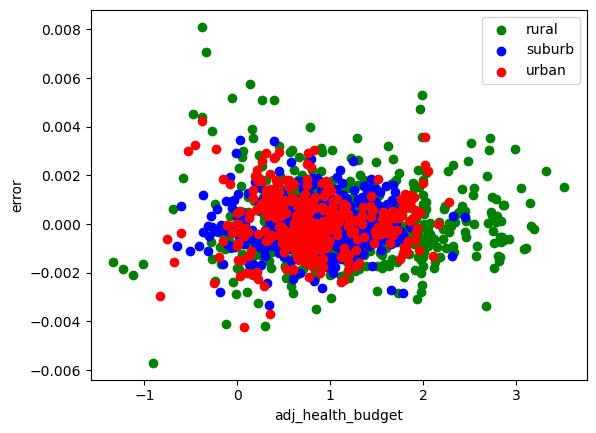

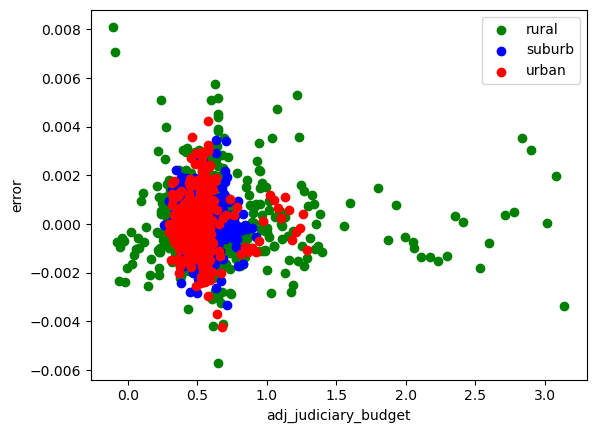

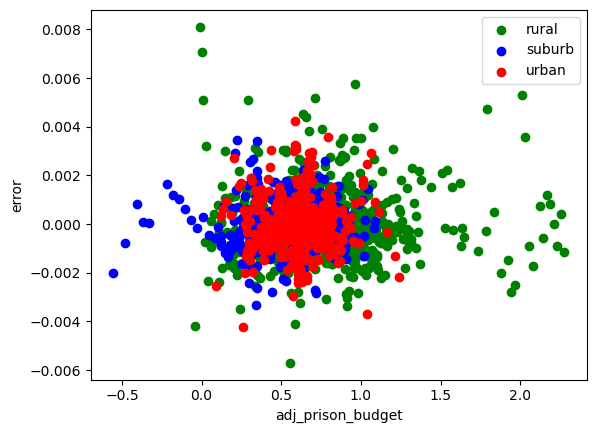

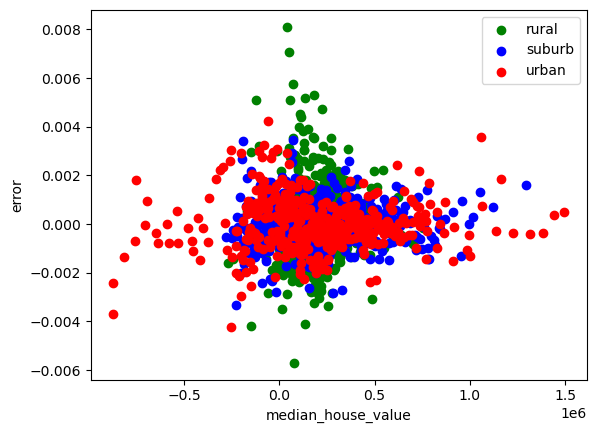

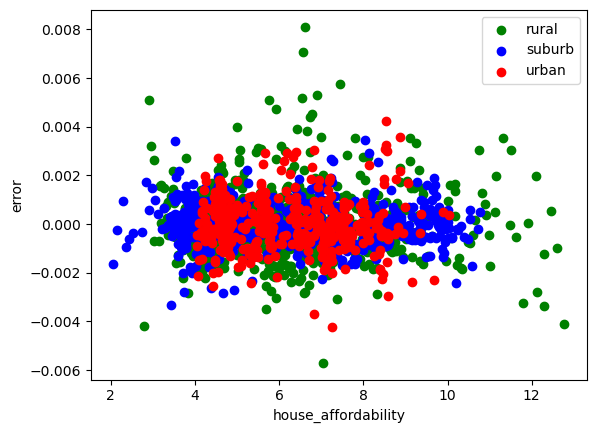

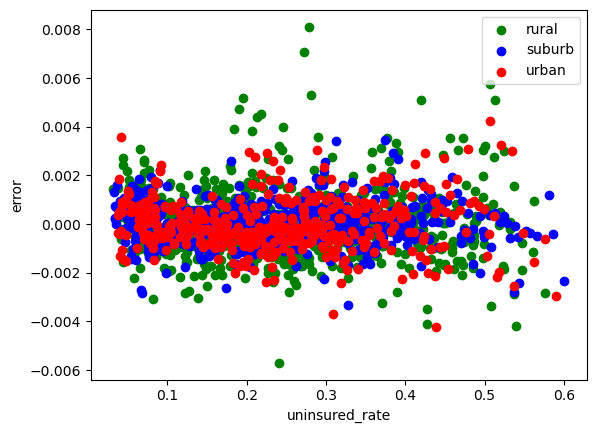

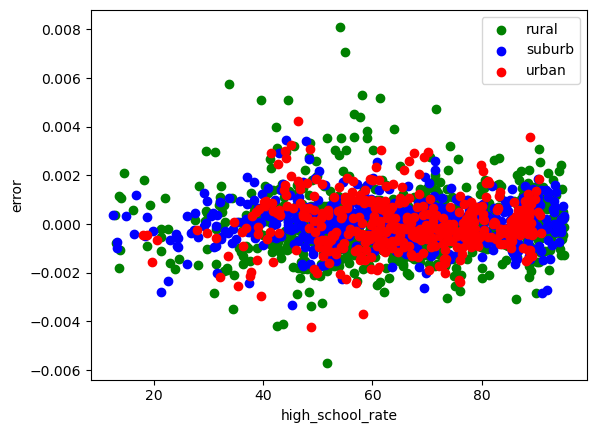

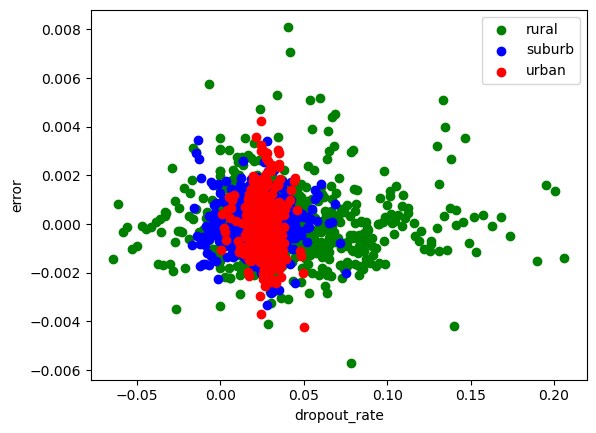

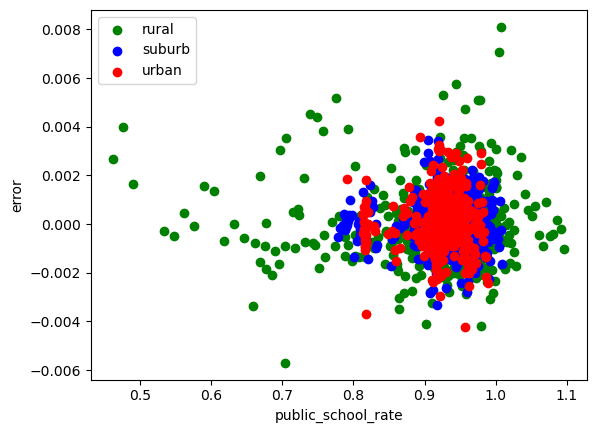

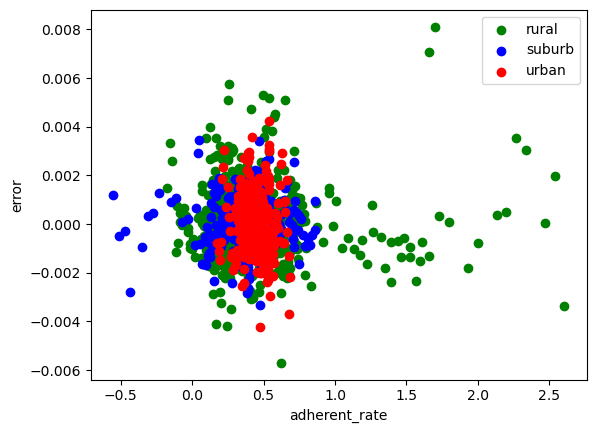

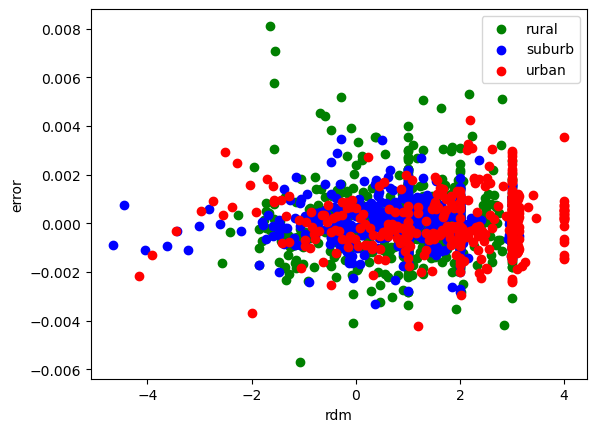

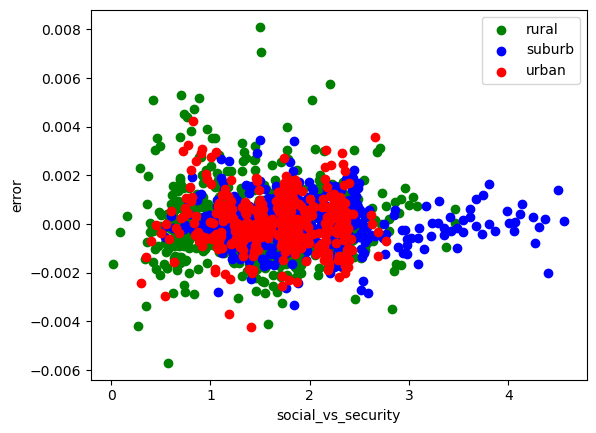

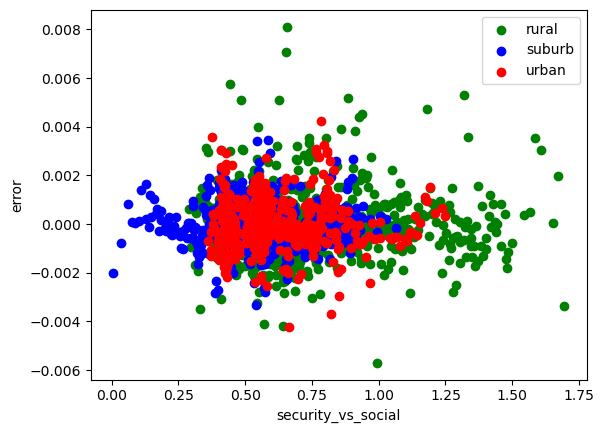

In [27]:
y_pred=fitted_Poly_models_Rural["mlr"].predict(Poly_df[Rural_Poly_features])
y=ytrain_Rural

rur=Xtrain_Rural.copy()
rur["error"]=y-y_pred

for xx in feature_0:
    plt.Figure(figsize=(10,6))
    plt.scatter(rur[xx],rur["error"],c='green',label='rural')
    plt.scatter(sub[xx],sub["error"],c='blue',label='suburb')
    plt.scatter(urb[xx],urb["error"],c='red',label='urban')
    plt.xlabel(xx)
    plt.ylabel('error')
    plt.legend()
    plt.show()

 Observations:


  1. We see that in urban, suburban and rural, when plot against population density and population, the data points from these three categories have very different concentrations. Correspondingly, the variance of the erros is a lot worse in rural, where population & population density is concentrated in zero.
  
  2. The mlr predictions seems to be unbiased for all the features

# Why does Rural model perform worse than Urban model?

In [28]:
print(Urban_df.groupby("County")["crime_rate"].std().mean())
print(Suburban_df.groupby("County")["crime_rate"].std().mean())
print(Rural_df.groupby("County")["crime_rate"].std().mean())

0.001950660611226517
0.0012505150330413702
0.001679873938261043


Observation:
The Rural_df has the largest variation in clearance_rate. This is because we are not able to get the accurate clearance rate when the number of population is small. When std of clearance rate in a county is big, it is hard to predict the crime rate.

In [52]:
tentative_df.groupby("Category")["clearance_rate"].std()

Category
Rural       0.187197
Suburban    0.090279
Urban       0.087214
Name: clearance_rate, dtype: float64

average is std of clearance_rate in Urban counties 0.05557676354424867
average is std of clearance_rate in Suburban counties 0.07222465876027392
average is std of clearance_rate in Rural counties 0.13916938673780851


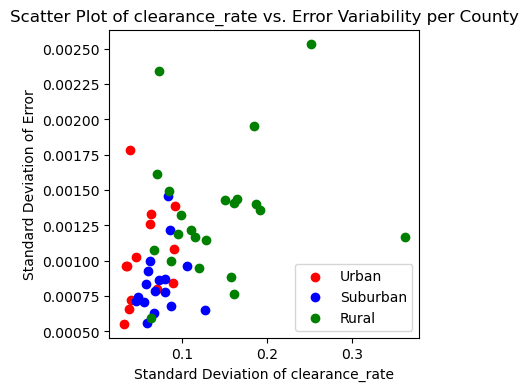

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
xx='clearance_rate'
print(f'average is std of {xx} in Urban counties' ,Urban_df.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Suburban counties',Suburban_df.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Rural counties',Rural_df.groupby("County")[xx].std().mean())

# Compute the standard deviation for each county (using the first level of the index, 'County')
urb_std = urb.groupby(level='County')[[xx, 'error']].std()
sub_std = sub.groupby(level='County')[[xx, 'error']].std()
rur_std = rur.groupby(level='County')[[xx, 'error']].std()

# Create a scatter plot: x-axis is std of clearance_rate and y-axis is std of error
plt.figure(figsize=(4, 4))
plt.scatter(urb_std[xx], urb_std['error'], c='red', label='Urban')
plt.scatter(sub_std[xx], sub_std['error'], c='blue', label='Suburban')
plt.scatter(rur_std[xx], rur_std['error'], c='green', label='Rural')
plt.legend()
plt.xlabel(f'Standard Deviation of {xx}')
plt.ylabel('Standard Deviation of Error')
plt.title(f'Scatter Plot of {xx} vs. Error Variability per County')
plt.show()


In [53]:
tentative_df.groupby("Category")["uninsured_rate"].std()

Category
Rural       0.050897
Suburban    0.051648
Urban       0.051114
Name: uninsured_rate, dtype: float64

average is std of uninsured_rate in Urban counties 0.11623947321274129
average is std of uninsured_rate in Suburban counties 0.11491553296276041
average is std of uninsured_rate in Rural counties 0.11712247473842323


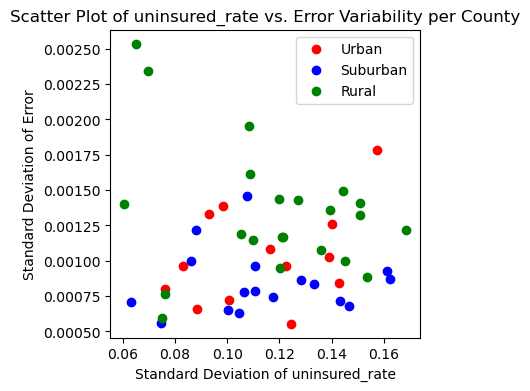

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
xx='uninsured_rate'
print(f'average is std of {xx} in Urban counties' ,Urban_df.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Suburban counties',Suburban_df.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Rural counties',Rural_df.groupby("County")[xx].std().mean())

# Compute the standard deviation for each county (using the first level of the index, 'County')
urb_std = urb.groupby(level='County')[[xx, 'error']].std()
sub_std = sub.groupby(level='County')[[xx, 'error']].std()
rur_std = rur.groupby(level='County')[[xx, 'error']].std()

# Create a scatter plot: x-axis is std of clearance_rate and y-axis is std of error
plt.figure(figsize=(4, 4))
plt.scatter(urb_std[xx], urb_std['error'], c='red', label='Urban')
plt.scatter(sub_std[xx], sub_std['error'], c='blue', label='Suburban')
plt.scatter(rur_std[xx], rur_std['error'], c='green', label='Rural')
plt.legend()
plt.xlabel(f'Standard Deviation of {xx}')
plt.ylabel('Standard Deviation of Error')
plt.title(f'Scatter Plot of {xx} vs. Error Variability per County')
plt.show()


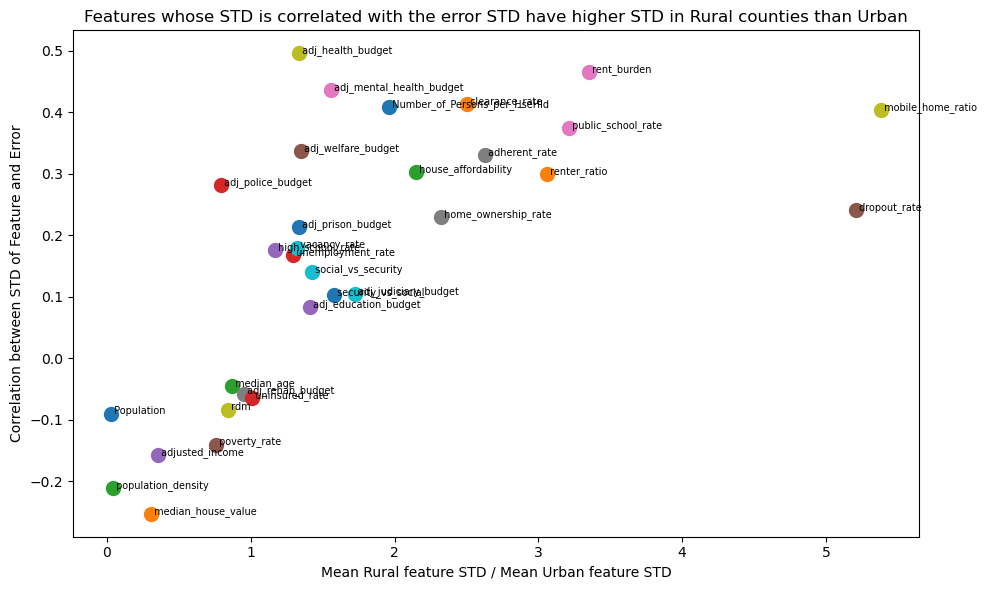

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Dictionaries to store the combined correlation coefficient and the error ratio for each feature
corr_dict = {}
ratio_dict = {}

for xx in feature_0:
    #print("\nFeature:", xx)
    
    # Compute standard deviations grouped by county for each dataset
    urb_std = urb.groupby(level='County')[[xx, 'error']].std()
    sub_std = sub.groupby(level='County')[[xx, 'error']].std()
    rur_std = rur.groupby(level='County')[[xx, 'error']].std()
    
    # Calculate the mean standard deviation of error for urban and rural counties
    mean_urb_error = Urban_df.groupby("County")[xx].std().mean()
    mean_rur_error = Rural_df.groupby("County")[xx].std().mean()
    
    # Compute the ratio: mean rural error std divided by mean urban error std
    ratio = mean_rur_error / mean_urb_error
    ratio_dict[xx] = ratio

    # Combine the standard deviations from all groups
    combined_std = pd.concat([urb_std, sub_std, rur_std])
    
    # Compute the Pearson correlation coefficient between the std of xx and error across all counties
    combined_corr = combined_std[xx].corr(combined_std['error'])
    corr_dict[xx] = combined_corr
    
    #print("Combined correlation:", combined_corr, "Error Ratio:", ratio)
    
    # Optional: Plot the scatter plot for each feature individually
    #plt.figure(figsize=(8, 6))
    #plt.scatter(urb_std[xx], urb_std['error'], c='red', label='Urban')
    #plt.scatter(sub_std[xx], sub_std['error'], c='blue', label='Suburban')
    #plt.scatter(rur_std[xx], rur_std['error'], c='green', label='Rural')
    #plt.xlabel(f'Standard Deviation of {xx}')
    #plt.ylabel('Standard Deviation of Error')
    #plt.title(f'Scatter Plot of {xx} vs. Error Variability per County')
    #plt.legend()
    #plt.show()

# Create a scatter plot: x-axis is the error ratio and y-axis is the correlation coefficient
plt.figure(figsize=(10, 6))
for xx in feature_0:
    x_val = ratio_dict[xx]
    y_val = corr_dict[xx]
    plt.scatter(x_val, y_val, s=100)  # s sets the marker size
    plt.text(x_val, y_val, f' {xx}', fontsize=7)  # Annotate each point with the feature name

plt.xlabel('Mean Rural feature STD / Mean Urban feature STD')
plt.ylabel('Correlation between STD of Feature and Error')
plt.title('Features whose STD is correlated with the error STD have higher STD in Rural counties than Urban')
plt.tight_layout()
plt.show()


It seems that whenever the std of feature is correlated with the std of the error of our models, then that feature has higher std in rural counties